In [2]:
#%load_ext autoreload
#%autoreload 2
import numpy as np
from vvasp.VizClasses import NeuropixelsChronicHolder
from vvasp.atlas_utils import Atlas as VvaspAtlas
import pyvista as pv
from labdata.schema import *
from labdata import chronic_paper as cp

[2024-05-21 14:48:16,514][INFO]: Connecting mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306
[2024-05-21 14:48:17,056][INFO]: Connected mmelin@churchland-data.cmojfwfr0b9t.us-west-2.rds.amazonaws.com:3306


In [9]:
from labdata.schema import *

subject = 'MM011'
targets = [['ACA','CP'], ['MOp','CP'], ['VISp']]
targets = [['CP'], ['CP']]
holder_ids = [0,4,0]
holder_ids = [4,4]
#hemisphere = 'left'
hemispheres = [['left'],['right']]

sdict = dict(subject_name=subject,
             procedure_type='chronic implant')
keys = (ProbeInsertion() & sdict).proj().fetch(as_dict=True, order_by='insertion_ap')
for hems, targs, id, key in zip(hemispheres, targets, holder_ids, keys):
    key['holder_id'] = id
    cp.ChronicInsertion.insert1(key, skip_duplicates=True)
    #(cp.ChronicInsertion & key).delete()
    for h,targ in zip(hems,targs):
        key['region_acronym'] = targ
        key['atlas_id'] = 'allen-ccf'	
        #key['hemisphere'] = hemisphere
        key['hemisphere'] = h
        cp.ChronicInsertion.TargetedRegion().insert1(key, skip_duplicates=True, ignore_extra_fields=True)


In [12]:
cp.ChronicInsertion & dict(subject_name=subjects[-1])

subject_name unique mouse id,procedure_type Defines procedures that are not an experimental session,procedure_datetime,probe_id probe id to keep track or re-uses,holder_id
MM018,chronic implant,2024-02-15 11:00:00,19454421152,0
MM018,chronic implant,2024-02-15 11:00:00,20097916182,0
MM018,chronic implant,2024-02-15 11:00:00,20097916222,0


In [13]:
#plotter = pv.Plotter(notebook=True)
#plotter.show()
import cv2
from pathlib import Path
from pyvistaqt import BackgroundPlotter
from tqdm import tqdm
plotter = BackgroundPlotter()
savedir = Path(r'C:\Data\churchland\chronic_manuscript_figs\raw_plots\trajectories')
subjects = np.unique(cp.ChronicInsertion().fetch('subject_name', order_by='procedure_datetime'))
imgs = []
for subj2plot in tqdm(subjects):
    insertions = ProbeInsertion * cp.ChronicInsertion() & f'subject_name = "{subj2plot}"'
    insertions = insertions.fetch(as_dict=True)

    regions_to_show = cp.ChronicInsertion().TargetedRegion() & f'subject_name = "{subj2plot}"'
    regions_to_show = regions_to_show.fetch('region_acronym','hemisphere', as_dict=True)
    atlas = VvaspAtlas(plotter, min_tree_depth=6, max_tree_depth=8)
    for region in regions_to_show:
        atlas.add_atlas_region_mesh(region['region_acronym'], region['hemisphere'], force_replot=True)

    prbs = []
    for i, entrypoint in enumerate(insertions):
        entry_point = [entrypoint['insertion_ml'], entrypoint['insertion_ap']]
        depth = entrypoint['insertion_depth']
        angles = [entrypoint['insertion_el'], entrypoint['insertion_spin'], entrypoint['insertion_az']]
        if entrypoint['holder_id'] == 0:
            prb = NeuropixelsChronicHolder('NP1','head_fixed', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 1:
            prb = NeuropixelsChronicHolder('NP1','freely_moving', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 2:
            prb = NeuropixelsChronicHolder('NP24','head_fixed', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 3:
            prb = NeuropixelsChronicHolder('NP24','freely_moving', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 4:
            prb = NeuropixelsChronicHolder('NP24a','head_fixed', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 5:
            prb = NeuropixelsChronicHolder('NP24a','freely_moving', plotter, root_intersection_mesh=atlas.meshes['root'])
        else:
            raise ValueError('Holder ID not recognized')

        prb.drive_probe_from_entry(entry_point, angles, depth)
        prb.make_inactive()
        prbs.append(prb)

    plotter.isometric_view()
    plotter.camera.position = np.array(plotter.camera.position) * .8 - np.array([-10000,0,36000])
    #plotter.camera.position = (48743.171132539625, 37047.24303377419, 14626.300531977657)
    #plotter.camera.focal_point = (-5529.047647635011, -7648.9577710917965, 9324.864101662535)
    #print(plotter.camera.position)
    #print(plotter.camera.focal_point)
    img = plotter.screenshot(savedir / f'{subj2plot}_trajectories.png', return_img=True, scale=5)
    #font_scale = 100
    #font_color = (0,0,0)
    #font_thickness = 2
    #position = (0,0)
    #img = cv2.putText(img.copy(), subj2plot, position, cv2.FONT_HERSHEY_SIMPLEX , font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)
    imgs.append(img)

100%|██████████| 10/10 [00:52<00:00,  5.29s/it]


In [14]:
#plotter.save_graphic(savedir / f'{SUBJECT}_trajectories.pdf', raster=False)
def tile_images(image_list, grid_size):
    """
    Tiles a list of RGB images into a single image.
    
    :param image_list: List of RGB images (as numpy arrays).
    :param grid_size: Tuple (rows, cols) indicating the grid size.
    :return: Tiled image as a numpy array.
    """
    rows, cols = grid_size
    #assert len(image_list) == rows * cols, "Number of images does not match grid size"

    # Get the shape of the images
    img_height, img_width, img_channels = image_list[0].shape

    # Create an empty array for the tiled image
    tiled_image = np.zeros((rows * img_height, cols * img_width, img_channels), dtype=np.uint8) + 255

    # Populate the tiled image
    origins = []
    for idx, img in enumerate(image_list):
        row_idx = idx // cols
        col_idx = idx % cols
        tiled_image[row_idx * img_height:(row_idx + 1) * img_height,
                    col_idx * img_width:(col_idx + 1) * img_width, :] = img
        origins.append((row_idx * img_height, col_idx * img_width))

    return tiled_image, origins

im,origins = tile_images(imgs, (3,4))

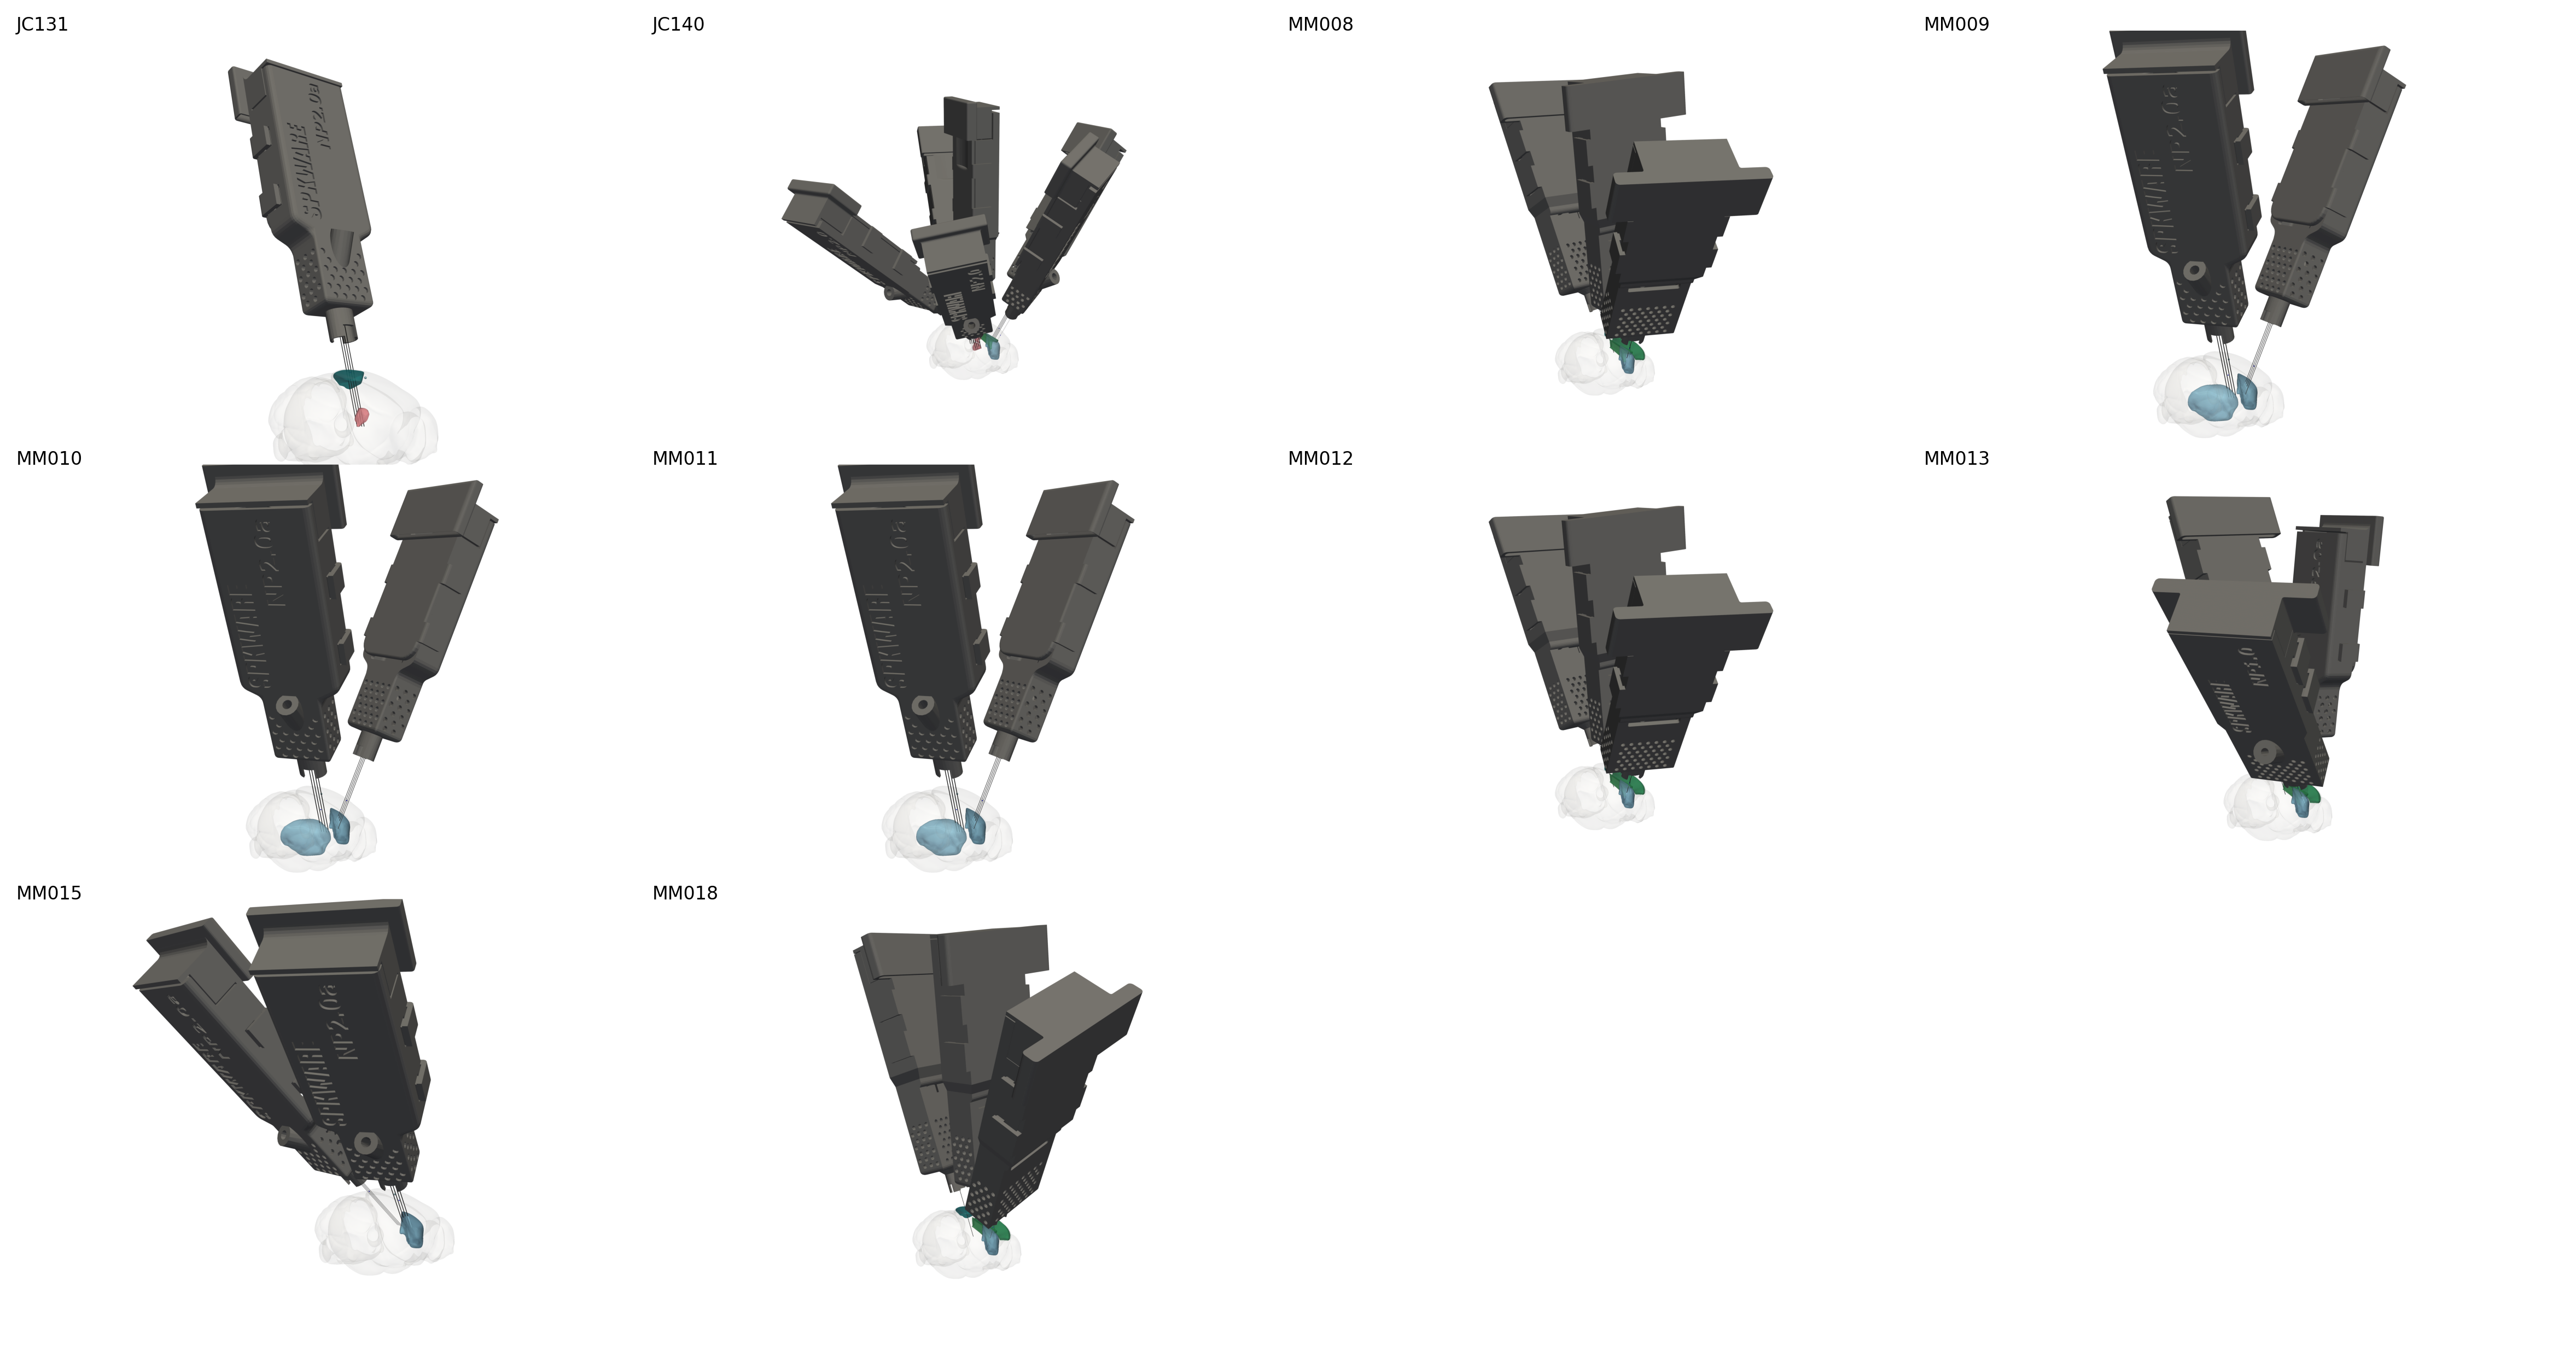

In [15]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.figure(figsize=(20,30), dpi=300)
plt.axis('off')
plt.imshow(im)
for s, o in zip(subjects,origins):
    plt.text(o[1], o[0], s, fontsize=8, color='black')
#plt.savefig(savedir / 'all_trajectories.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.savefig(savedir / 'all_trajectories.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
for subj2plot in tqdm(['MM009']):
    insertions = ProbeInsertion * cp.ChronicInsertion() & f'subject_name = "{subj2plot}"'
    insertions = insertions.fetch(as_dict=True)

    regions_to_show = cp.ChronicInsertion().TargetedRegion() & f'subject_name = "{subj2plot}"'
    regions_to_show = regions_to_show.fetch('region_acronym','hemisphere', as_dict=True)
    atlas = VvaspAtlas(plotter, min_tree_depth=6, max_tree_depth=8)
    for region in regions_to_show:
        atlas.add_atlas_region_mesh(region['region_acronym'], region['hemisphere'], force_replot=True)

    prbs = []
    for i, entrypoint in enumerate(insertions):
        entry_point = [entrypoint['insertion_ml'], entrypoint['insertion_ap']]
        depth = entrypoint['insertion_depth']
        angles = [entrypoint['insertion_el'], entrypoint['insertion_spin'], entrypoint['insertion_az']]
        if entrypoint['holder_id'] == 0:
            prb = NeuropixelsChronicHolder('NP1','head_fixed', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 1:
            prb = NeuropixelsChronicHolder('NP1','freely_moving', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 2:
            prb = NeuropixelsChronicHolder('NP24','head_fixed', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 3:
            prb = NeuropixelsChronicHolder('NP24','freely_moving', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 4:
            prb = NeuropixelsChronicHolder('NP24a','head_fixed', plotter, root_intersection_mesh=atlas.meshes['root'])
        elif entrypoint['holder_id'] == 5:
            prb = NeuropixelsChronicHolder('NP24a','freely_moving', plotter, root_intersection_mesh=atlas.meshes['root'])
        else:
            raise ValueError('Holder ID not recognized')

        prb.drive_probe_from_entry(entry_point, angles, depth)
        prb.make_inactive()
        prbs.append(prb)

    plotter.isometric_view()


100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


In [73]:
plotter.isometric_view()
plotter.camera.position = np.array(plotter.camera.position) * .8 - np.array([-10000,0,30000])

In [ ]:
ProbeInsertion & 'subject_name="MM009"'